<h1 align="center">Introduction to Machine Learning - 25737-2</h1>
<h4 align="center">Dr. R. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>


**<font color='red'>Plagiarism is strongly prohibited!</font>**


**Student Name**: Ehsan Merrikhi

**Student ID**: 400101967


# ****Support Vector Machines****

In this notebook, you will implement SVM for three datasets. You will become more familiar with the Soft-Margin SVM and the Kernel trick, which makes SVM extremely powerful.

Before we start our implementation, you must be comfortable with the theoretical details of the Soft-Margin SVM as an optimization problem and be able to derive the dual formulation for this problem. In the next sections, you will solve the dual optimization problem for all datasets using the CVXPY library, which has been developed for solving convex optimization problems. To get more familiar with CVXPY programming, you can use this [link](https://www.cvxpy.org).

This is the primal formulation for the Soft-Margin SVM for linearly separable data with slack variables $\xi_i \ge 0$:

\begin{equation*}
\begin{aligned}
& {\text{min.}}
& & \frac{1}{2} \|w\|^2 + C \sum_{i=1}^{N} \xi_i \\
& \text{s.t.}
& & y_i(w^T x_i + b) \geq 1 - \xi_i, \; i = 1, \ldots, N \\
& & & \xi_i \geq 0, \; i = 1, \ldots, N
\end{aligned}
\end{equation*}

Where $w$ represents the weight vector, $b$ is the bias term, and $C$ is the regularization parameter controlling the trade-off between a wide margin and misclassification.

**Theoretical Questions:**

1) Derive the dual optimization problem for the Soft-Margin SVM.



2) How do we calculate the weights and bias ($w$ and $b$) using the dual problem optimum points?

3) How do we classify new data points using the optimal weights and bias?

<font color='green'>Write down your answers as markdown here.</font>

**1.**

$$
L(\mathbf{w}, b, \xi, \alpha, \mu) = \frac{1}{2} \|\mathbf{w}\|^2 + C \sum_{i=1}^N \xi_i - \sum_{i=1}^N \alpha_i \left[ y_i (\mathbf{w} \cdot \mathbf{x}_i + b) - 1 + \xi_i \right] - \sum_{i=1}^N \mu_i \xi_i
$$

$$
\begin{align*}
\frac{\partial L}{\partial \mathbf{w}} &= \mathbf{w} - \sum_{i=1}^N \alpha_i y_i \mathbf{x}_i = 0 \implies \mathbf{w} = \sum_{i=1}^N \alpha_i y_i \mathbf{x}_i \\[10pt]
\frac{\partial L}{\partial b} &= -\sum_{i=1}^N \alpha_i y_i = 0 \implies \sum_{i=1}^N \alpha_i y_i = 0 \\[10pt]
\frac{\partial L}{\partial \xi_i} &= C - \alpha_i - \mu_i = 0 \implies \alpha_i + \mu_i = C
\end{align*}
$$
$$
\begin{align*}
\rightarrow \text{Dual problem:} 
\newline
& \max_{\alpha} \sum_{i=1}^N \alpha_i - \frac{1}{2} \sum_{i=1}^N \sum_{j=1}^N \alpha_i \alpha_j y_i y_j \mathbf{x}_i \cdot \mathbf{x}_j \\[10pt]
&\text{subject to:} \quad 0 \leq \alpha_i \leq C, \quad \sum_{i=1}^N \alpha_i y_i = 0
\end{align*}
$$

**2.**

$$
\begin{align*}
\mathbf{w} = & \sum_{i=1}^N \alpha_i y_i \mathbf{x}_i \\[10pt]
b = & \frac{1}{|S|} \sum_{i \in S} \left( y_i - \mathbf{w} \cdot \mathbf{x}_i \right)
\end{align*}
$$

**3.**

$$
\hat{y} = \text{sign}(\mathbf{w} \cdot \mathbf{x} + b)
$$


Sometimes, the data is not linearly separable. Therefore, the previous formulation of the Soft-Margin SVM does not give a good accuracy for the classification problem. The Kernel trick is a technique used in such situations. Consider $x$ as your input features with dimension $p$. One can use function $\phi: R^p → R^d$ to map the input features to another space with dimension $d$. Finding good $\phi$ such that data points become near linearly separable makes the previous formulation of the problem and its dual useful by replacing $\phi(x_i)$ for $x_i$ in the problem definition. The function $\phi(x)$ can even be a mapping to an infinite-dimensional space.

If you have found the correct dual form of the Soft-Margin SVM in the previous formulation, you can see that the terms $x_i^T x_j$ will appear in the problem formulation and the prediction rule. These terms will be replaced with $\phi(x_i)^T \phi(x_j)$ when we use $\phi$ as our feature mapping function. Given a feature mapping $\phi$ we define its corresponding **Kernel** to be:

\begin{equation*}
\begin{aligned}
& K(x, z) = \phi(x)^T \phi(z)
\end{aligned}
\end{equation*}

Hence, in the dual optimization problem and the prediction rule of the Soft-Margin SVM, we can replace all terms in the form $x^T z$ with $K(x, z)$. This technique is called the Kernel trick.

Now, given $\phi$, we could easily compute $K(x,z)$ by finding $\phi(x)$ and $\phi(z)$ and taking their inner product. But what’s more interesting is that often, $K(x,z)$ may be very inexpensive to calculate, even though $\phi(x)$ itself may be very expensive to calculate (perhaps because it is an extremely high-dimensional vector). Check Stanford's CS229 [notes](https://see.stanford.edu/materials/aimlcs229/cs229-notes3.pdf) on SVM and the Kernel trick for more details and examples.

## Libraries

Here are some useful libraries for the implementation. You can add or remove any libraries as you wish. Note that you cannot use sklearn or similar libraries for implementation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import cvxpy as cp

## **Dataset Exploration**

In this notebook, you'll be working with three datasets, specifically named "DF1.csv", "DF2.csv", and "DF3.csv". Each dataset entry is composed of a 2-dimensional feature vector and a label, which is either "1" or "-1". The primary objective of this notebook is to leverage SVM to develop a robust classifier for each dataset.

You are given three kernels as follows:



1.   Linear Kernel: $K(x, z) = x^T z$
2.   Polynomial Kernel of degree 2: $K(x, z) = (1 + ∑_{i = 1}^{p} x_i z_i)^2$, where $p$ is the dimension of the feature space.
3.   RBF Kernel: $K(x, z) = e^{-\frac{||x-z||_2^2}{2σ^2}}$

Before implementing, you must choose the correct kernel for each dataset. Note that each kernel must be used exactly for one dataset. Therefore, you cannot use one of the kernels twice. As a part of our grading scheme, what matters with respect to accuracy is the sum of the accuracies you reach for all three datasets, and the accuracy of each model does not have any separate score. Thus, it would help if you chose the most appropriate kernel for each dataset so that all datasets reach a reasonably good accuracy.





Load all datasets and show the first 5 rows of each.

In [2]:
df1 = pd.read_csv('DF1.csv')
df2 = pd.read_csv('DF2.csv')
df3 = pd.read_csv('DF3.csv')

print("First 5 rows of DF1.csv:")
print(df1.head())

print("\nFirst 5 rows of DF2.csv:")
print(df2.head())

print("\nFirst 5 rows of DF3.csv:")
print(df3.head())

First 5 rows of DF1.csv:
         x1        x2  y
0  6.462652  5.121478 -1
1 -6.586541 -7.721287  1
2  9.239683 -8.595738 -1
3  4.250052  2.143755  1
4  8.219779 -3.609733 -1

First 5 rows of DF2.csv:
         x1         x2  y
0  2.937145  77.102291  1
1 -0.029344  44.802353  1
2  5.868818  44.595757 -1
3  8.609281  49.223945 -1
4  7.763276 -14.340750 -1

First 5 rows of DF3.csv:
         x1        x2  y
0 -0.517768 -0.466158 -1
1  0.940985  0.235175  1
2 -0.470720  0.917120  1
3  0.712716 -0.097401 -1
4 -0.608773 -0.107034 -1


Use the following function to visualize the datapoints for all datasets.

(1476, 2)


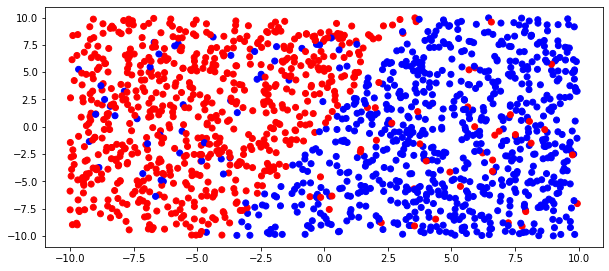

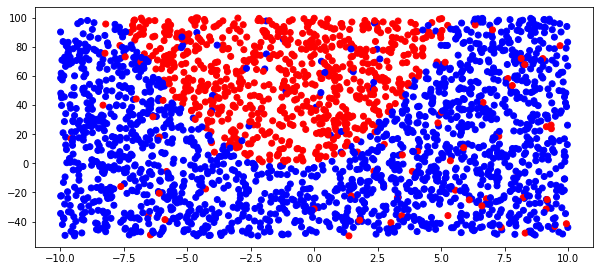

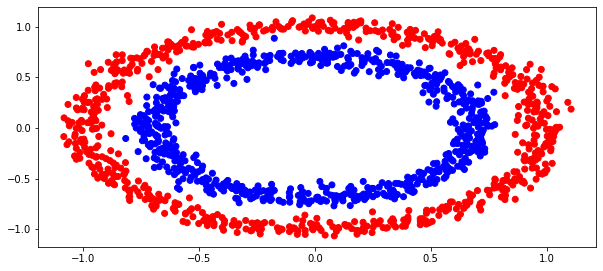

In [3]:
def visualize_data(X, y):
  col = []
  for i in range(len(y)):
    if y[i] == 1:
      col.append('red')
    else:
      col.append('blue')
  plt.scatter(X[ : , 0], X[ : , 1], color = col)
  plt.show()

## YOUR CODE HERE
X1, y1 = df1[['x1', 'x2']].values, df1['y'].values
X2, y2 = df2[['x1', 'x2']].values, df2['y'].values
X3, y3 = df3[['x1', 'x2']].values, df3['y'].values

print(X1.shape)
plt.figure(figsize=(10,15))
plt.subplot(3,1,1)
visualize_data(X=X1, y=y1)
plt.figure(figsize=(10,15))
plt.subplot(3,1,2)
visualize_data(X=X2, y=y2)
plt.figure(figsize=(10,15))
plt.subplot(3,1,3)
visualize_data(X=X3, y=y3)

**Theoretical Question:**

Which kernel will you use for each dataset? Justify your answer.

Note: your implementation must follow your choice here. Otherwise, you do not recieve any points for your implemetation.

<font color='green'>Write down your answers as markdown here.</font>

*I use linear kernel for the first dataset because looking at its shape it's obvious they are approximately seperable with a line*

*I use polynomial kernel for the second dataset because they are seperable with a second order kernel*

*I use RBF kernel for the third dataset because they look like two gaussians*

## Dataset one (DF1.csv)

Split the dataset into train and test sets (20 percent for test). Use 42 as the random state and do not forget to scale the data.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform(X_test)

Use CVXPY to solve the dual problem with the appropriate kernel using the training set.

In [21]:
m, n = X_train.shape
y_train = y_train.astype(float)  # Ensure y_train is float for CVXPY

# Define the variables
alpha = cp.Variable(m)

# Define the kernel (linear in this case)
K = X_train @ X_train.T

# Construct the matrix for the quadratic form to ensure it's symmetric
Q = np.outer(y_train, y_train) * K

# Define the objective function (using DCP-compliant operations)
objective = cp.Maximize(cp.sum(alpha) - 0.5 * cp.quad_form(alpha, cp.psd_wrap(Q)))

# Define the constraints
constraints = [alpha >= 0, alpha <= 1, cp.sum(cp.multiply(alpha, y_train)) == 0]

# Solve the problem
problem = cp.Problem(objective, constraints)
problem.solve()

# Get the optimal values of alpha
alpha_opt = alpha.value

# Compute the weights
w = np.sum(alpha_opt[:, None] * y_train[:, None] * X_train, axis=0)

# Find the support vectors
support_vectors = np.where(alpha_opt > 1e-4)[0]

# Compute the bias term
b = np.mean(y_train[support_vectors] - X_train[support_vectors] @ w)

Predict the class of each entry in the test set using your learned model.

In [22]:
# Predict function
def predict(X, w, b):
    return np.sign(X @ w + b)

# Evaluate the model
y_train_pred = predict(X_train, w, b)
y_test_pred = predict(X_test, w, b)

Use classification_report function (from sklearn) to get the accuracy of your model.

In [24]:
print("Training classification report:")
print(classification_report(y_train, y_train_pred))

print("Testing classification report:")
print(classification_report(y_test, y_test_pred))

Training classification report:
              precision    recall  f1-score   support

        -1.0       0.92      0.92      0.92       618
         1.0       0.91      0.91      0.91       562

    accuracy                           0.92      1180
   macro avg       0.92      0.92      0.92      1180
weighted avg       0.92      0.92      0.92      1180

Testing classification report:
              precision    recall  f1-score   support

          -1       0.92      0.93      0.92       148
           1       0.93      0.92      0.92       148

    accuracy                           0.92       296
   macro avg       0.92      0.92      0.92       296
weighted avg       0.92      0.92      0.92       296



## Dataset two (DF2.csv)

Split the dataset into train and test sets (20 percent for test). Use 42 as the random state and do not forget to scale the data.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform(X_test)

Use CVXPY to solve the dual problem with the appropriate kernel using the training set.

In [26]:
# Polynomial kernel of degree 2
def polynomial_kernel(X1, X2, degree=2, coef0=1):
    return (X1 @ X2.T + coef0) ** degree

# Implement SVM with polynomial kernel using CVXPY
m, n = X_train.shape
y_train = y_train.astype(float)  # Ensure y_train is float for CVXPY

# Define the variables
alpha = cp.Variable(m)

# Define the kernel (polynomial kernel of degree 2 in this case)
K = polynomial_kernel(X_train, X_train, degree=2)

# Construct the matrix for the quadratic form to ensure it's symmetric
Q = np.outer(y_train, y_train) * K

# Define the objective function (using DCP-compliant operations)
objective = cp.Maximize(cp.sum(alpha) - 0.5 * cp.quad_form(alpha, cp.psd_wrap(Q)))

# Define the constraints
C = cp.Parameter(value=1.0, nonneg=True)  # Regularization parameter, can be adjusted
constraints = [alpha >= 0, alpha <= C, cp.sum(cp.multiply(alpha, y_train)) == 0]

# Solve the problem
problem = cp.Problem(objective, constraints)
problem.solve()

# Get the optimal values of alpha
alpha_opt = alpha.value

# Compute the weights (not explicitly used in non-linear SVM, but needed for decision function)
w = np.sum(alpha_opt[:, None] * y_train[:, None] * X_train, axis=0)

# Find the support vectors
support_vectors = np.where(alpha_opt > 1e-4)[0]

# Compute the bias term
b = np.mean(y_train[support_vectors] - np.sum(polynomial_kernel(X_train[support_vectors], X_train) * (alpha_opt * y_train), axis=1))


Predict the class of each entry in the test set using your learned model.

In [27]:
# Predict function using polynomial kernel
def predict(X, X_train, alpha_opt, y_train, b, degree=2, coef0=1):
    K = polynomial_kernel(X, X_train, degree, coef0)
    return np.sign(np.sum(K * (alpha_opt * y_train), axis=1) + b)

# Evaluate the model
y_train_pred = predict(X_train, X_train, alpha_opt, y_train, b)
y_test_pred = predict(X_test, X_train, alpha_opt, y_train, b)

Use classification_report function (from sklearn) to get the accuracy of your model.

In [28]:
print("Training classification report:")
print(classification_report(y_train, y_train_pred))

print("Testing classification report:")
print(classification_report(y_test, y_test_pred))

Training classification report:
              precision    recall  f1-score   support

        -1.0       0.96      0.94      0.95      1385
         1.0       0.86      0.91      0.89       595

    accuracy                           0.93      1980
   macro avg       0.91      0.92      0.92      1980
weighted avg       0.93      0.93      0.93      1980

Testing classification report:
              precision    recall  f1-score   support

          -1       0.94      0.91      0.93       336
           1       0.83      0.89      0.86       160

    accuracy                           0.90       496
   macro avg       0.89      0.90      0.89       496
weighted avg       0.91      0.90      0.90       496



## Dataset three (DF3.csv)

Split the dataset into train and test sets (20 percent for test). Use 42 as the random state and do not forget to scale the data.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size=0.2, random_state=42)

std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform(X_test)

Use CVXPY to solve the dual problem with the appropriate kernel using the training set.

In [30]:
# Gaussian (RBF) kernel function
def gaussian_kernel(X1, X2, gamma=0.1):
    sq_dists = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
    return np.exp(-gamma * sq_dists)

# Implement SVM with Gaussian kernel using CVXPY
m, n = X_train.shape
y_train = y_train.astype(float)  # Ensure y_train is float for CVXPY

# Define the variables
alpha = cp.Variable(m)

# Define the kernel (Gaussian in this case)
K = gaussian_kernel(X_train, X_train)

# Construct the matrix for the quadratic form to ensure it's symmetric
Q = np.outer(y_train, y_train) * K

# Use psd_wrap to ensure positive semi-definiteness
Q = cp.psd_wrap(Q)

# Define the objective function (using DCP-compliant operations)
objective = cp.Maximize(cp.sum(alpha) - 0.5 * cp.quad_form(alpha, Q))

# Define the constraints
constraints = [alpha >= 0, alpha <= cp.Parameter(value=1, nonneg=True), cp.sum(cp.multiply(alpha, y_train)) == 0]

# Solve the problem
problem = cp.Problem(objective, constraints)
problem.solve()

# Get the optimal values of alpha
alpha_opt = alpha.value

# Compute the weights (not explicitly used in non-linear SVM, but needed for decision function)
w = np.sum(alpha_opt[:, None] * y_train[:, None] * X_train, axis=0)

# Find the support vectors
support_vectors = np.where(alpha_opt > 1e-4)[0]

# Compute the bias term
b = np.mean(y_train[support_vectors] - np.sum(gaussian_kernel(X_train[support_vectors], X_train) * (alpha_opt * y_train), axis=1))

Predict the class of each entry in the test set using your learned model.

In [31]:
# Predict function using Gaussian kernel
def predict(X, X_train, alpha_opt, y_train, b, gamma=0.1):
    K = gaussian_kernel(X, X_train, gamma)
    return np.sign(np.sum(K * (alpha_opt * y_train), axis=1) + b)

# Evaluate the model
y_train_pred = predict(X_train, X_train, alpha_opt, y_train, b)
y_test_pred = predict(X_test, X_train, alpha_opt, y_train, b)

Use classification_report function (from sklearn) to get the accuracy of your model.

In [32]:
print("Training classification report:")
print(classification_report(y_train, y_train_pred))

print("Testing classification report:")
print(classification_report(y_test, y_test_pred))

Training classification report:
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00       578
         1.0       1.00      1.00      1.00       589

    accuracy                           1.00      1167
   macro avg       1.00      1.00      1.00      1167
weighted avg       1.00      1.00      1.00      1167

Testing classification report:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       152
           1       1.00      1.00      1.00       140

    accuracy                           1.00       292
   macro avg       1.00      1.00      1.00       292
weighted avg       1.00      1.00      1.00       292

